## Testing effects of finetuning on DistilBERT with SQUAD
Caleb Lehman

In [ ]:
%pip install transformers datasets evaluate


In [1]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator,pipeline
from tqdm.auto import tqdm
import numpy as np
from evaluate import load
import random


In [2]:
##load in squad from hugging face


squad_raw = load_dataset("squad",split="validation")
squad_for_columns = load_dataset("squad",split="train")
squad_for_columns = squad_for_columns.train_test_split(test_size=0.2)

cols = squad_for_columns["train"].column_names


In [17]:
squad_test = squad_raw.select(random.choices([i for i  in range(len(squad_raw))],k=1000)) ## get test set same as homework 3

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")


In [5]:
## preprocess function from hugging face to allow training and validation sets to be used by pytorch trainer
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs




In [6]:
## same evaluation function from hw 3

squad_evaluate = load('squad')

def evaluate_hf_model(model_name,model,tokenizer):

    processor = pipeline('question-answering', model=model, tokenizer=tokenizer)

    def dataset_generator(dataset):
        for ex in dataset:
            yield (ex,
                {'question' : ex['question'], 'context': ex['context']})
            
    predictions = []
    references = []

    # Get predictions, and save corresponding reference (if we were using the whole dataset, we wouldn't need this step)
    for ex in tqdm(dataset_generator(squad_test), total=len(squad_test)):

        predictions.append({
                'id' : ex[0]['id'],
                'prediction_text' : processor(ex[1])['answer']
        }
        )

        # In each example, there are multiple possible answers which we compare to. Here we are converting from them from the datasets format to the one expected by the evaluation metric. 
        references.append({
            'id' : ex[0]['id'],
            'answers' : [{'text' : z[0], 'answer_start' : z[1]} for z in zip(ex[0]['answers']['text'], ex[0]['answers']['answer_start'])]
        })

    # Compute metrics
    print('Performance of {} : {}'.format(model_name, squad_evaluate.compute(predictions=predictions, references=references)))



In [7]:
# now load in new trainging data
import json

## this will allow us to change the raw json datasat into one the model better understands
## every entry has one line with sections for column, ie idx, title etc...
def process_file(input_filename,output_filename):
    
    with open(input_filename) as f:
        dataset = json.load(f)

    with open(output_filename, "w") as f:
        for article in dataset["data"]:
            title = article["title"]
            for paragraph in article["paragraphs"]:
                context = paragraph["context"]
                answers = {}
                for qa in paragraph["qas"]:
                    question = qa["question"]
                    idx = qa["id"]
                    answers["text"] = [a["text"] for a in qa["answers"]]
                    answers["answer_start"] = [a["answer_start"] for a in qa["answers"]]
                    f.write(
                        json.dumps(
                            {
                                "id": idx,
                                "title": title,
                                "context": context,
                                "question": question,
                                "answers": answers,
                            }
                        )
                    )
                    f.write("\n")
        
        return load_dataset("json",data_files=output_filename)


## load in three of our datasets that were jsons. prompting, entity swap, and squad 2.0
changed_qa_dataset_raw = process_file("content/changedHowQuestionsAreAsked.json","content/changedHowQuestionsAreAsked.jsonl")
modified_dataset_raw = process_file("content/modified_squad_data.json","content/modified_squad_data.jsonl")
squad_2_raw = process_file("content/train-v2.0.json","content/train-v2.0.jsonl")




Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
import pandas as pd

## this takes a csv file and puts out a usable json (the pandas.dataFrame.to_json was not working correctly)
## also manually finds the answer start index using str.find(other_str)

def convert_to_squad_format(input_csv, output_json):
    # Read the CSV file
    data = pd.read_csv(input_csv)
    
    squad_data = {"data": []}
    i=0
    for index, row in data.iterrows():
        # Constructing a single SQuAD data entry
        squad_entry = {
            "paragraphs": [
                {
                    "context": row['context'],
                    "qas": [
                        {
                            "question": row['question'],
                            "id": i,
                            "answers": [
                                {
                                    "text": row['answer'],
                                    "answer_start": row['context'].find(row['answer'])
                                }
                            ]
                        }
                    ]
                }
            ]
        }
        i+=1
        squad_data["data"].append(squad_entry)
    
    # Write the SQuAD format to a JSON file
    with open(output_json, 'w') as f:
        json.dump(squad_data, f)

In [9]:
##load in final two datasets, answer in first half and synonym replacement

convert_to_squad_format("content/answer_in_first_half.csv","content/answer_in_first_half_fixed.json")
convert_to_squad_format("content/replaced_with_synonyms.csv","content/replaced_synonyms.json")


In [10]:
## this is gonna be used for the json outputted above, it is different in that there is no title for these datasets, which isn't used by the model
## instead of making a whole new function, could have sent the function a boolean if it needed a title or not, but this still works and hindsight is 20/20

def process_file_no_title(input_filename,output_filename):
    
    with open(input_filename) as f:
        dataset = json.load(f)

    with open(output_filename, "w") as f:
        for article in dataset["data"]:
            
            for paragraph in article["paragraphs"]:
                context = paragraph["context"]
                answers = {}
                for qa in paragraph["qas"]:
                    question = qa["question"]
                    idx = qa["id"]
                    answers["text"] = [a["text"] for a in qa["answers"]]
                    answers["answer_start"] = [a["answer_start"] for a in qa["answers"]]
                    f.write(
                        json.dumps(
                            {
                                "id": idx,
                                
                                "context": context,
                                "question": question,
                                "answers": answers,
                            }
                        )
                    )
                    f.write("\n")
        
        return load_dataset("json",data_files=output_filename)

In [11]:
## load in final two datasets to usable json
answers_in_first_raw = process_file_no_title("content/answer_in_first_half_fixed.json","content/answer_in_first_half.jsonl")
with_synonyms_raw = process_file_no_title("content/replaced_synonyms.json", "content/replaced_synonyms.jsonl")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
##take our usable json we made from the function above, and get our training and validation sets
## 20% split, 100 for training, 25 for validation
## training sets only has columns train and test, so test will become our validation set
## model still does not see actual test set in training or validation, so all good



changed_qa_dataset = changed_qa_dataset_raw["train"].select(random.choices([i for i  in range(len(changed_qa_dataset_raw))],k=125))
modified_dataset = modified_dataset_raw["train"].select(random.choices([i for i  in range(len(modified_dataset_raw))],k=125))
squad_2 = squad_2_raw["train"].select(random.choices([i for i  in range(len(squad_2_raw))],k=125))
answers_in_first = answers_in_first_raw["train"]
with_synonyms = with_synonyms_raw["train"]


## squad 2.0 
squad_2_train = squad_2.train_test_split(test_size=0.2)["train"]
squad_2_valid = squad_2.train_test_split(test_size=0.2)["test"]

## prompting
changed_qa_dataset_train = changed_qa_dataset.train_test_split(test_size=0.2)["train"]
changed_qa_dataset_valid = changed_qa_dataset.train_test_split(test_size=0.2)["test"]

## entity swapping
modified_dataset_train = modified_dataset.train_test_split(test_size=0.2)["train"]
modified_dataset_valid = modified_dataset.train_test_split(test_size=0.2)["test"]

## first half answers only
answers_in_first_train = answers_in_first.train_test_split(test_size=0.01)["train"]
answers_in_first_valid = answers_in_first.train_test_split(test_size=0.01)["test"]

## swapping synonyms
with_synonyms_train = with_synonyms.train_test_split(test_size=0.01)["train"]
with_synonyms_valid = with_synonyms.train_test_split(test_size=0.01)["test"]




In [13]:
## tokenize all the training and validation data for pytorch trainer

tokenized_train_squad = squad_2_train.map(preprocess_function,batched=True,remove_columns=cols)
tokenized_valid_squad = squad_2_valid.map(preprocess_function,batched=True,remove_columns=cols)

tokenized_train_qa = changed_qa_dataset_train.map(preprocess_function,batched=True,remove_columns=cols)
tokenized_valid_qa = changed_qa_dataset_valid.map(preprocess_function,batched=True,remove_columns=cols)

tokenized_train_modify = modified_dataset_train.map(preprocess_function,batched=True,remove_columns=cols)
tokenized_valid_modify = modified_dataset_valid.map(preprocess_function,batched=True,remove_columns=cols)

tokenized_train_first_half = answers_in_first_train.map(preprocess_function,batched=True,remove_columns=answers_in_first.column_names)
tokenized_valid_first_half = answers_in_first_valid.map(preprocess_function,batched=True,remove_columns=answers_in_first.column_names)

tokenized_train_synonym = with_synonyms_train.map(preprocess_function,batched=True,remove_columns=answers_in_first.column_names)
tokenized_valid_synonym = with_synonyms_valid.map(preprocess_function,batched=True,remove_columns=answers_in_first.column_names)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

## Training

A fresh model is loaded in from huggingface and then a new pytorch trainer is loaded in with the same training specifications. Each model is then trained on the modified datasets and then tested using the evaluate hf model function. The final scores are below with a histogram showing both their total scores and their scores relative to the baseline.

In [34]:
## baseline model from pretrained and then finetuned on squad 2.0. this was chosen as the baseline as all modified datasets are variations of squad 2.0.

model_squad_2 = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")


args = TrainingArguments(
    "distilbert-finetuned",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_squad_2,
    args=args,
    train_dataset=tokenized_train_squad,
    eval_dataset=tokenized_valid_squad,
    tokenizer=tokenizer,
)
trainer.train()

  0%|          | 0/130 [00:00<?, ?it/s]

{'train_runtime': 137.055, 'train_samples_per_second': 7.296, 'train_steps_per_second': 0.949, 'train_loss': 0.013755639699789194, 'epoch': 10.0}


TrainOutput(global_step=130, training_loss=0.013755639699789194, metrics={'train_runtime': 137.055, 'train_samples_per_second': 7.296, 'train_steps_per_second': 0.949, 'total_flos': 97989825024000.0, 'train_loss': 0.013755639699789194, 'epoch': 10.0})

In [14]:
## model trained on prompting


model_qa_change = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")


args = TrainingArguments(
    "distilbert-finetuned",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_qa_change,
    args=args,
    train_dataset=tokenized_train_qa,
    eval_dataset=tokenized_valid_qa,
    tokenizer=tokenizer,
)
trainer.train()


Map:   0%|          | 0/125 [00:00<?, ? examples/s]

  0%|          | 0/130 [00:00<?, ?it/s]

{'train_runtime': 137.7108, 'train_samples_per_second': 7.262, 'train_steps_per_second': 0.944, 'train_loss': 0.013933869508596567, 'epoch': 10.0}


TrainOutput(global_step=130, training_loss=0.013933869508596567, metrics={'train_runtime': 137.7108, 'train_samples_per_second': 7.262, 'train_steps_per_second': 0.944, 'total_flos': 97989825024000.0, 'train_loss': 0.013933869508596567, 'epoch': 10.0})

In [24]:
## model trained on entity swapped data set

model_modify = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")


args = TrainingArguments(
    "distilbert-finetuned",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_modify,
    args=args,
    train_dataset=tokenized_train_modify,
    eval_dataset=tokenized_valid_modify,
    tokenizer=tokenizer,
)
trainer.train()

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

  0%|          | 0/130 [00:00<?, ?it/s]

{'train_runtime': 135.798, 'train_samples_per_second': 7.364, 'train_steps_per_second': 0.957, 'train_loss': 0.30575009859525243, 'epoch': 10.0}


TrainOutput(global_step=130, training_loss=0.30575009859525243, metrics={'train_runtime': 135.798, 'train_samples_per_second': 7.364, 'train_steps_per_second': 0.957, 'total_flos': 97989825024000.0, 'train_loss': 0.30575009859525243, 'epoch': 10.0})

In [14]:
## model trained on dataset where answer is in the first half

model_first_half = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")

args = TrainingArguments(
    "distilbert-finetuned",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_first_half,
    args=args,
    train_dataset=tokenized_train_first_half,
    eval_dataset=tokenized_valid_first_half,
    tokenizer=tokenizer,
)
trainer.train()


  0%|          | 0/140 [00:00<?, ?it/s]

{'train_runtime': 144.7666, 'train_samples_per_second': 7.322, 'train_steps_per_second': 0.967, 'train_loss': 0.027193740436008997, 'epoch': 10.0}


TrainOutput(global_step=140, training_loss=0.027193740436008997, metrics={'train_runtime': 144.7666, 'train_samples_per_second': 7.322, 'train_steps_per_second': 0.967, 'total_flos': 103869214525440.0, 'train_loss': 0.027193740436008997, 'epoch': 10.0})

In [14]:
## model trained on synonym swapped words

model_synonyms = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")

args = TrainingArguments(
    "distilbert-finetuned",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_synonyms,
    args=args,
    train_dataset=tokenized_train_synonym,
    eval_dataset=tokenized_valid_synonym,
    tokenizer=tokenizer,
)
trainer.train()

  0%|          | 0/140 [00:00<?, ?it/s]

{'train_runtime': 147.9196, 'train_samples_per_second': 7.436, 'train_steps_per_second': 0.946, 'train_loss': 1.2371253967285156, 'epoch': 10.0}


TrainOutput(global_step=140, training_loss=1.2371253967285156, metrics={'train_runtime': 147.9196, 'train_samples_per_second': 7.436, 'train_steps_per_second': 0.946, 'total_flos': 107788807526400.0, 'train_loss': 1.2371253967285156, 'epoch': 10.0})

In [50]:
score1 = evaluate_hf_model("Squad 2.0",model_squad_2,tokenizer) #squad benchmark

  0%|          | 0/1000 [00:00<?, ?it/s]

Performance of Squad 2.0 : {'exact_match': 70.3, 'f1': 81.33044327048492}


In [15]:
score2 = evaluate_hf_model("Changed QA",model_qa_change,tokenizer) #prompting

  0%|          | 0/1000 [00:00<?, ?it/s]

Performance of Changed QA : {'exact_match': 71.9, 'f1': 82.99819386331268}


In [55]:
score3 = evaluate_hf_model("Modify set",model_modify,tokenizer) #entity relation change

  0%|          | 0/1000 [00:00<?, ?it/s]

Performance of Modify set : {'exact_match': 68.4, 'f1': 80.13096139058352}


In [19]:
score4 = evaluate_hf_model("First half answers",model_first_half,tokenizer) # first half answers

  0%|          | 0/1000 [00:00<?, ?it/s]

Performance of First half answers : {'exact_match': 73.4, 'f1': 82.41293567192801}


In [54]:
score5 = evaluate_hf_model("Synonyms",model_synonyms,tokenizer) # synonym swapped words

  0%|          | 0/1000 [00:00<?, ?it/s]

Performance of Synonyms : {'exact_match': 70.0, 'f1': 78.91873135257083}


In [16]:

#these are the original score values to be used. if f1 score above different it is due to rerunning cells
y = [81.33044,78.918731,80.13096,82.488933,82.97429]
x = ["Baseline","Synonym","Entity Swap","First Half","Prompting"]

(-0.5, 4.5, 75.0, 85.0)

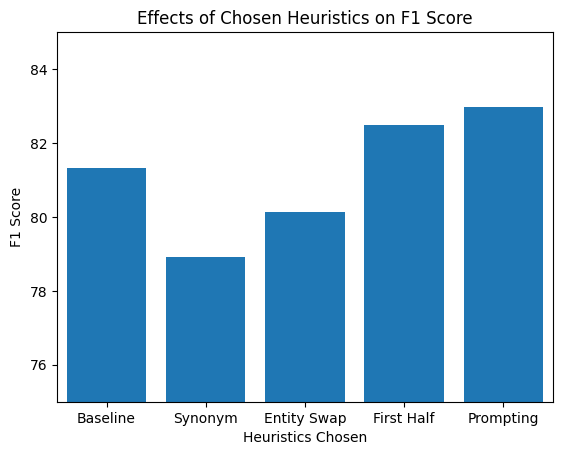

In [17]:
import matplotlib.pyplot as plt

plt.bar(x,y,color='tab:blue',width=0.8)
plt.xlabel("Heuristics Chosen")
plt.ylabel("F1 Score")
plt.title("Effects of Chosen Heuristics on F1 Score")
plt.axis([-.5,4.5,75,85])

Text(0.5, 1.0, 'Distances of each Heuristic to the Baseline')

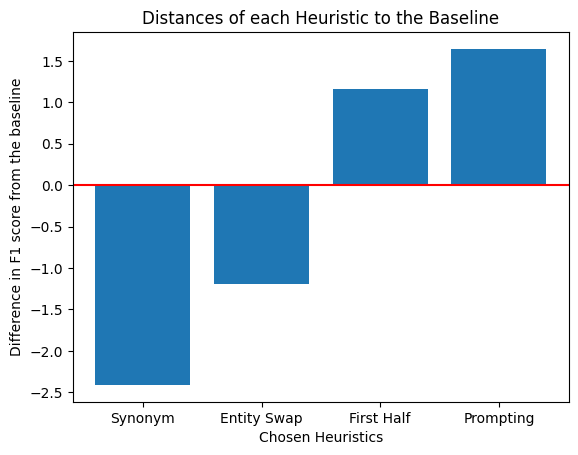

In [18]:
y0 = [78.918731,80.13096,82.488933,82.97429]
y1 = np.array(y0)
y2 = y1 - y[0]

x2 = ["Synonym","Entity Swap","First Half","Prompting"]

plt.bar(x2,y2,color="tab:blue",width =.8)
plt.axhline(y=0,color='r',linestyle='-')
plt.xlabel("Chosen Heuristics")
plt.ylabel("Difference in F1 score from the baseline")
plt.title("Distances of each Heuristic to the Baseline")